In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

<ipython-input-1-721442f17053>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Нейронная сеть


Layer - абстрактный класс, представляющий слой нейронной сети.


In [2]:
class Layer:
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __str__(self):
        pass

    def forward(self):
        pass

    def backward(self):
        pass

    def optimize(self):
        pass

Linear - подкласс, представляющий линейный слой сети. Персептрон. Изначальные веса и смещение рандомные.


In [3]:
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.rand(output_dim, input_dim)
        self.biases = np.random.rand(output_dim, 1)

        self.type = "Linear"

    def __str__(self):
        return f"{self.type} Layer"

    # прямой проход для подсчёта функции потерь
    def forward(self, input_val):
        self._prev_acti = input_val
        return np.matmul(self.weights, input_val) + self.biases

    # обратный проход для посчёта градиента
    def backward(self, dA):
        dW = dA @ self._prev_acti.T
        dB = dA.mean()

        delta = self.weights.T @ dA

        return delta, dW, dB

    # оптимизация коэффициентов нейронов через использование антиградиента
    # нужно для уменьшения функции потерь
    def optimize(self, dW, dB, rate):
        self.weights -= rate * dW
        self.biases -= rate * dB

ReLU - подкласс, представляющий нелинейный слой с функцией активации ReLU (Rectified Linear Unit).

In [4]:
class ReLU(Layer):
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = "ReLU"

    def __str__(self):
        return f"{self.type} Layer"

    def forward(self, input_val):
        self._prev_acti = np.maximum(0, input_val)
        return self._prev_acti

    def backward(self, dJ):
        return dJ * np.heaviside(self._prev_acti, 0)

Sigmoid - подкласс, представляющий нелинейный слой с функцией активации сигмоида.

In [5]:
class Sigmoid(Layer):
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = "Sigmoid"

    def __str__(self):
        return f"{self.type} Layer"

    def forward(self, input_val):
        self._prev_acti = 1 / (1 + np.exp(-input_val))
        return self._prev_acti

    def backward(self, dJ):
        sig = self._prev_acti
        return dJ * sig * (1 - sig)

 Класс, представляющий функцию потерь бинарной кросс-энтропии.

 Функция кросс-энтропии стремится к минимуму, когда предсказанные вероятности близки к истинным меткам, и увеличивается с увеличением расхождения между ними.

In [6]:
class BinaryCrossEntropy:
    def __init__(self, predicted, real):
        self.real = real
        self.predicted = predicted
        self.type = "Binary Cross-Entropy"

    def forward(self):
        n = self.real.shape[0]
        loss = np.nansum(-self.real @ np.log(self.predicted) - (1 - self.real) @ np.log(1 - self.predicted)) / n
        return np.squeeze(loss)

    def backward(self):
        n = self.real.shape[0]
        return (-(self.real / self.predicted.T) + ((1 - self.real) / (1 - self.predicted.T))) / n

Класс, представляющий модель нейронной сети.   
Содержит список слоев (layers) и список значений функции потерь (loss).

In [8]:
class Model:
    def __init__(self):
        self.layers = []
        self.loss = []

    # добавление нового слоя к модели
    def add(self, layer):
        self.layers.append(layer)

    # функция предсказывания результатов
    def predict(self, X):
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(X)
            X = forward

        return forward

    # выполнение одной эпохи обучения (прогон по всем данным)
    def _run_epoch(self, X, Y, learning_rate):

        # прямой проход, получаем предсказания
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(input_val=X)
            X = forward

        # подсчёт функции потерь и градиента
        bce = BinaryCrossEntropy(forward.T, Y)
        error = bce.forward()
        gradient = bce.backward()

        # обратный проход
        for i, _ in reversed(list(enumerate(self.layers))):
            if self.layers[i].type != "Linear":
                gradient = self.layers[i].backward(gradient)
            else:
                gradient, dW, dB = self.layers[i].backward(gradient)
                # print(dW, dB) # вывод весов и порога/смещения в каждую эпоху
                self.layers[i].optimize(dW, dB, learning_rate)

        return error

    # обучение модели, проводим для датасета определлённое количество эпох
    def train(self, X_train, Y_train, learning_rate, epochs, verbose=False):
        for epoch in range(epochs):
            loss = self._run_epoch(X_train, Y_train, learning_rate)
            self.loss.append(loss)
            if verbose and epoch % 50 == 0:
                print(f"Epoch: {epoch}. Loss: {loss}")
        return self.loss

# Создание и обучение модели нейронной сети

## Модель и данные из семинара

### Данные для обучения

In [19]:
# Создаем DataFrame
data = {
    'X1 (температура)': [1, 9.4, 2.5, 8.0, 0.5, 7.9, 7.0, 2.8, 1.2, 7.8],
    'X2 (вибрация)': [1, 6.4, 2.1, 7.7, 2.2, 8.4, 7.0, 0.8, 3.0, 6.1],
    'Y (опасность)': [1, -1, 1, -1, 1, -1, -1, 1, 1, -1]
}

df = pd.DataFrame(data)

# Выводим DataFrame
print(df)

   X1 (температура)  X2 (вибрация)  Y (опасность)
0               1.0            1.0              1
1               9.4            6.4             -1
2               2.5            2.1              1
3               8.0            7.7             -1
4               0.5            2.2              1
5               7.9            8.4             -1
6               7.0            7.0             -1
7               2.8            0.8              1
8               1.2            3.0              1
9               7.8            6.1             -1


Преобразуем данные для работы.

In [20]:
for col in df.columns[0:]:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

df = df.astype(float)

# Выводим обновленный DataFrame
print(df)

   X1 (температура)  X2 (вибрация)  Y (опасность)
0          0.056180       0.026316            1.0
1          1.000000       0.736842            0.0
2          0.224719       0.171053            1.0
3          0.842697       0.907895            0.0
4          0.000000       0.184211            1.0
5          0.831461       1.000000            0.0
6          0.730337       0.815789            0.0
7          0.258427       0.000000            1.0
8          0.078652       0.289474            1.0
9          0.820225       0.697368            0.0


Делим данные, будем определять по температуре и вибрации опасно или безопасно. Также делим на тестовые данные и тренировочные.

In [21]:
X = df.drop("Y (опасность)", axis=1)
y = df["Y (опасность)"].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# преобразуем массив в нужную форму
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Работа нейронной сети

In [22]:
# Создаём модель
model = Model()

# Добавляем слои.
model.add(Linear(X.shape[1], 1)) # рецепторов столько же сколько признаков (2), 1 выход
model.add(Sigmoid(1))

# Обучаем модель
error = model.train(X_train = X.T.to_numpy(),
            Y_train = y,
            learning_rate = 0.05, # величина шага обновления коэффициентов (на сколько сильно обновляются веса), влияет на скорость обучения
            epochs=2000,
            verbose=True)

Epoch: 0. Loss: 0.9750827359391285
Epoch: 50. Loss: 0.6462483959424518
Epoch: 100. Loss: 0.5131253353724945
Epoch: 150. Loss: 0.45527402419535123
Epoch: 200. Loss: 0.42455341281522224
Epoch: 250. Loss: 0.40485606556145903
Epoch: 300. Loss: 0.3902702484793228
Epoch: 350. Loss: 0.3783465422479964
Epoch: 400. Loss: 0.3679607751802963
Epoch: 450. Loss: 0.3585530415954321
Epoch: 500. Loss: 0.3498251517439187
Epoch: 550. Loss: 0.341608811623207
Epoch: 600. Loss: 0.3338037863918925
Epoch: 650. Loss: 0.32634711590500365
Epoch: 700. Loss: 0.3191970331596498
Epoch: 750. Loss: 0.3123242262266676
Epoch: 800. Loss: 0.30570693323317555
Epoch: 850. Loss: 0.29932811262834136
Epoch: 900. Loss: 0.29317377189400506
Epoch: 950. Loss: 0.28723195971530613
Epoch: 1000. Loss: 0.28149214646067283
Epoch: 1050. Loss: 0.27594483617862975
Epoch: 1100. Loss: 0.2705813188539824
Epoch: 1150. Loss: 0.2653935088391476
Epoch: 1200. Loss: 0.26037383690554844
Epoch: 1250. Loss: 0.25551517605509116
Epoch: 1300. Loss: 0.250

Итоговые веса для каждого признака:

In [23]:
model.layers[0].weights

array([[-2.63032614, -2.471869  ]])

Функция потерь:

Text(0.5, 0, 'Epoch')

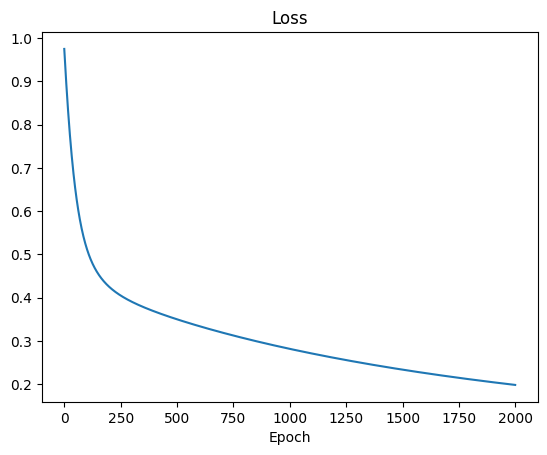

In [24]:
plt.plot(error)
plt.title("Loss")
plt.xlabel("Epoch")

Проверим точность на оставшихся/тестовых данных и на всём датасете:

In [25]:
print("accuracy", accuracy_score(model.predict(X_test.T.to_numpy()).reshape(-1) > 0.5, y_test.reshape(-1)))

accuracy 1.0


In [26]:
print("accuracy", accuracy_score(model.predict(X.T.to_numpy()).reshape(-1) > 0.5, y.reshape(-1)))

accuracy 1.0


Построим график разделения по классам данных, выразив один из признаков через второй + используя полученные веса и порог:

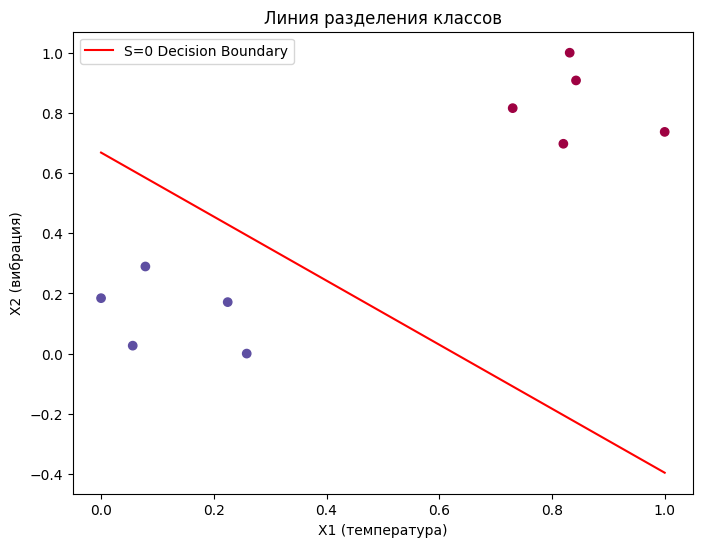

In [29]:
def plot_decision_boundary(X, y, weights, biases):
    # Решающая граница: S = k1*X1 + k2*X2 + biases = 0
    x1_min, x1_max = df['X1 (температура)'].min(), df['X1 (температура)'].max()
    x2_min, x2_max = df['X2 (вибрация)'].min(), df['X2 (вибрация)'].max()

    x1 = np.linspace(x1_min, x1_max, 100)
    x2 = (-biases - weights[0][0]*x1) / weights[0][1]

    # Рисуем график
    plt.figure(figsize=(8, 6))
    plt.plot(x1, x2, label='S=0 Decision Boundary', color='red')
    plt.scatter(X['X1 (температура)'], X['X2 (вибрация)'], c=y, cmap=plt.cm.Spectral)
    plt.title('Линия разделения классов')
    plt.xlabel('X1 (температура)')
    plt.ylabel('X2 (вибрация)')
    plt.legend()
    plt.show()

# Ваши веса и смещение
weights = model.layers[0].weights
biases = model.layers[0].biases[0][0]

# Выведем график
plot_decision_boundary(X, y, weights, biases)


Итоговая формула модели:

In [30]:
k1 = model.layers[0].weights[0][0]
k2 = model.layers[0].weights[0][1]
biases = model.layers[0].biases[0][0]

print(f"Y = sigamoid(S = {k1}*x1 {k2}*x2 + {biases} > 0)")


Y = sigamoid(S = -2.6303261413830428*x1 -2.471869003686366*x2 + 1.6514517972235851 > 0)


## Титаник

Данные для обучения взяты с https://www.kaggle.com/competitions/titanic/data

### Данные для обучения

1. **Survived:**
   - Тип данных: Бинарный (0 или 1).
   - Описание: Показывает, выжил ли пассажир (1) или нет (0).

2. **Pclass:**
   - Тип данных: Категориальный (1, 2 или 3).
   - Описание: Обозначает класс билета пассажира (1 - первый класс, 2 - второй класс, 3 - третий класс).

3. **Sex:**
   - Тип данных: Категориальный (мужской или женский).
   - Описание: Указывает на пол пассажира.

4. **Age:**
   - Тип данных: Вещественный (число с плавающей запятой).
   - Описание: Показывает возраст пассажира. Могут быть пропущенные значения.

5. **SibSp:**
   - Тип данных: Целочисленный (количество братьев/сестер/супругов на борту + пассажир).
   - Описание: Показывает количество родственников пассажира (братьев, сестер, супругов) на борту.

6. **Parch:**
   - Тип данных: Целочисленный (количество родителей/детей на борту + пассажир).
   - Описание: Показывает количество родителей или детей пассажира на борту.

7. **Fare:**
   - Тип данных: Вещественный (число с плавающей запятой).
   - Описание: Обозначает стоимость билета, за который заплатил пассажир.

8. **Embarked:**
   - Тип данных: Категориальный (C, Q или S).
   - Описание: Показывает порт, в котором пассажир сел на борт (C - Шербур, Q - Квинстаун, S - Саутгемптон).

In [31]:
df = pd.read_csv("titanic.csv").drop(["PassengerId", "Ticket", "Cabin", "Name"], axis=1)
df["Embarked"] = df["Embarked"].fillna("")
df = df.fillna(0)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Предобработка данных. Присваиваем численные значения.

In [32]:
df["Sex"] = df["Sex"] == "male"
encoder = LabelEncoder()
df["Embarked"] = encoder.fit_transform(df["Embarked"])
for col in df.columns[1:]:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
df = df.astype(float)

 Разбиваем данные. Будем определять выжил ли пассажир или нет в зависимости от его характеристик.

In [33]:
X = df.drop("Survived", axis=1)
y = df["Survived"].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# преобразуем массив в нужную форму
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Работа нейронной сети

In [34]:
# Создаём модель
model = Model()

# Добавляем слои. Чередуем их для извлечения возможных сложных зависимостей. Количество нейронов в промежуточных слоях выбрано случайно.
model.add(Linear(X.shape[1], 5)) # рецепторов столько же сколько признаков (7), 5 выходов
model.add(ReLU(5)) # к каждому выходу прошлого слоя применяем ReLu (5 входов), и, в итоге, получается слой с 5 выходами

model.add(Linear(5,2)) # новый слой с 5 входами (прошлые от ReLu) и выход 2 нейрона
model.add(ReLU(2)) # к каждому выходу прошлого слоя применяем ReLu (2 входа), и, в итоге, получается слой с 2 выходами

model.add(Linear(2,1)) # сводим всё к одному нейрону
model.add(Sigmoid(1))

# Обучаем модель
error = model.train(X_train = X.T.to_numpy(),
            Y_train = y,
            learning_rate = 0.05, # величина шага обновления коэффициентов (на сколько сильно обновляются веса), влияет на скорость обучения
            epochs=9000,
            verbose=True)

Epoch: 0. Loss: 3.6689551305106654
Epoch: 50. Loss: 0.634643846357754
Epoch: 100. Loss: 0.6254319726921059
Epoch: 150. Loss: 0.6132367933603405
Epoch: 200. Loss: 0.5954521282702302
Epoch: 250. Loss: 0.5694506246151404
Epoch: 300. Loss: 0.5362473171523063
Epoch: 350. Loss: 0.5052029017493985
Epoch: 400. Loss: 0.4860597977373881
Epoch: 450. Loss: 0.477370021449194
Epoch: 500. Loss: 0.4734271060785178
Epoch: 550. Loss: 0.4710972973641341
Epoch: 600. Loss: 0.4693094808883117
Epoch: 650. Loss: 0.46774314643334763
Epoch: 700. Loss: 0.46629945504938847
Epoch: 750. Loss: 0.46494524920022706
Epoch: 800. Loss: 0.46366863615872544
Epoch: 850. Loss: 0.4624652859033284
Epoch: 900. Loss: 0.4613337066252983
Epoch: 950. Loss: 0.46027343779341945
Epoch: 1000. Loss: 0.4592842838469807
Epoch: 1050. Loss: 0.4583659460932885
Epoch: 1100. Loss: 0.4575178205598772
Epoch: 1150. Loss: 0.45673887742341984
Epoch: 1200. Loss: 0.4560275922732013
Epoch: 1250. Loss: 0.4553819187375378
Epoch: 1300. Loss: 0.4547992975

Вывод коэффициентов каждого линейного слоя. По матрице: один массив - коэффициенты от каждого входа к одному выходу.

In [35]:
model.layers[0].weights

array([[ 0.74790273,  1.11385446,  0.46625044,  1.18527949,  0.57479106,
         0.12841505,  0.51287638],
       [ 0.15133692,  0.33472333,  0.53078817, -0.09737578,  0.30529567,
         0.42303675,  0.06454898],
       [-0.3401331 , -0.20347305,  0.05555902, -0.29831937,  0.59472212,
         0.4957019 ,  0.4435278 ],
       [ 0.36729972,  0.99033967,  0.81822247,  0.95087765,  0.60362966,
         0.55235218,  0.85053558],
       [ 0.03445115,  0.04591936, -0.07328149,  0.55163116, -0.19791635,
         0.3223364 ,  0.02490187]])

In [36]:
model.layers[2].weights

array([[ 0.68097834,  0.6133913 , -0.29573003,  0.89111271,  0.29227986],
       [-0.38622228,  0.52087786,  1.13275865, -0.36360995,  1.20271922]])

In [37]:
model.layers[4].weights

array([[-0.65724394,  1.85556181]])

График функции потерь:

Text(0.5, 0, 'Epoch')

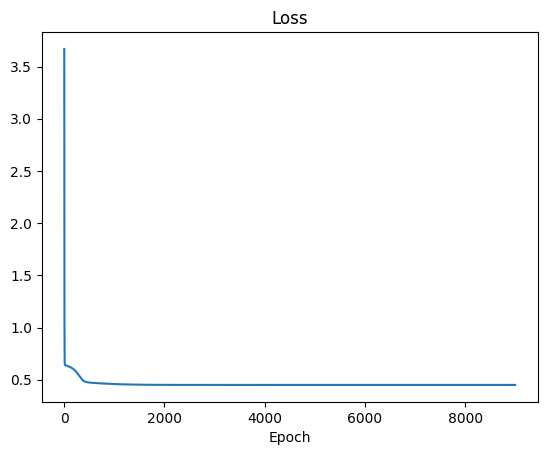

In [38]:
plt.plot(error)
plt.title("Loss")
plt.xlabel("Epoch")

Проверим на тестовых данных, посмотрим точность модели:

In [39]:
print("accuracy", accuracy_score(model.predict(X_test.T.to_numpy()).reshape(-1) > 0.5, y_test.reshape(-1)))

accuracy 0.7821229050279329
